In [5]:
import os
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils  # For displaying a grid of images
import matplotlib.pyplot as plt


In [7]:

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Initialize paths and labels
        root_dir = "rps"
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # Define class labels based on folder structure
        self.class_labels = {'paper': 0, 'rock': 1, 'scissors': 2}

        # Loop through each subfolder and collect file paths and labels
        for class_name, label in self.class_labels.items():
            folder_path = os.path.join(root_dir, class_name)
            print(f"Looking for images in: {folder_path}")  # Print folder path for verification
            # print(folder_path)
            # Adjust extension if needed; this assumes .jpg images
            image_paths = glob(os.path.join(folder_path, '*.PNG'))
            if not image_paths:
                print(f"No images found in {folder_path}. Check if the folder and images are present.")
            else:
                print(f"Found {len(image_paths)} images in {folder_path}")

            self.file_paths.extend(image_paths)
            self.labels.extend([label] * len(image_paths))

        # Check if files were loaded
        if len(self.file_paths) == 0:
            raise ValueError("No images found in the specified root_dir path. Check the folder structure and paths.")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        image = Image.open(self.file_paths[index]).convert("RGB")  # Ensure image is in RGB
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


  
        



In [8]:

# Define the transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [9]:
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [10]:

# Set root directory
root_dir = "rps"

# Initialize datasets
train_dataset = CustomImageDataset(root_dir=root_dir, transform=train_transform)
val_dataset = CustomImageDataset(root_dir=root_dir, transform=val_transform)


Looking for images in: rps\paper
Found 840 images in rps\paper
Looking for images in: rps\rock
Found 840 images in rps\rock
Looking for images in: rps\scissors
Found 840 images in rps\scissors
Looking for images in: rps\paper
Found 840 images in rps\paper
Looking for images in: rps\rock
Found 840 images in rps\rock
Looking for images in: rps\scissors
Found 840 images in rps\scissors


In [11]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


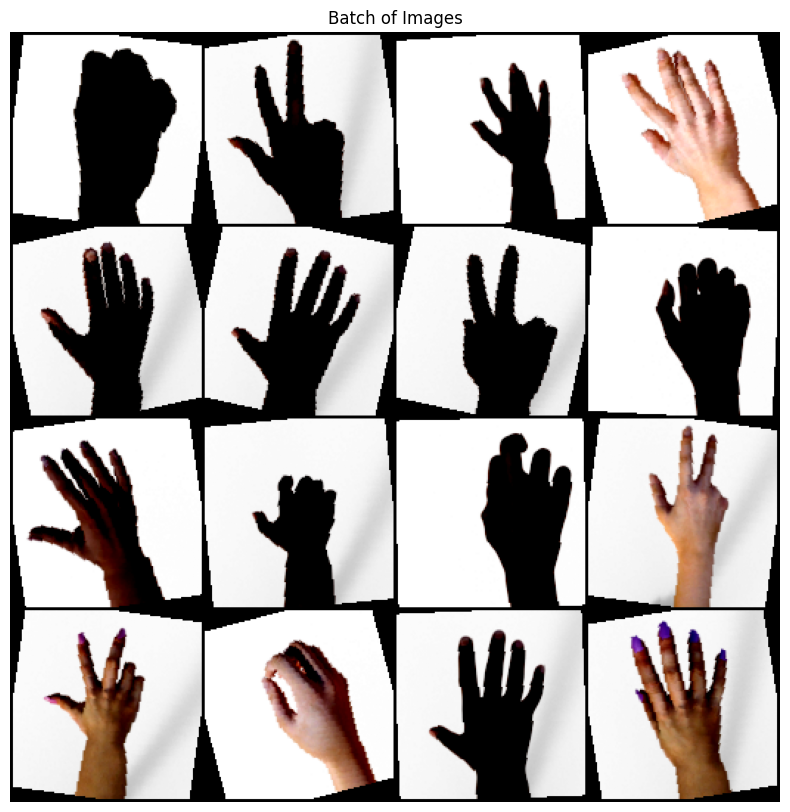

In [12]:

# Display a batch of images
def show_batch(loader):
    # Get a batch of images
    images, labels = next(iter(loader))
    
    # Display the images in a grid
    grid_img = vutils.make_grid(images, nrow=4, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))  # Rearrange dimensions for plotting
    plt.title("Batch of Images")
    plt.axis("off")
    plt.show()

# Display a batch from the training loader
show_batch(train_loader)

# Home Task 6(B)

100%|██████████| 170M/170M [03:36<00:00, 787kB/s]  


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/50], Loss: 1421.6346, Accuracy: 32.54%
Epoch [2/50], Loss: 1238.9376, Accuracy: 42.10%
Epoch [3/50], Loss: 1168.9816, Accuracy: 45.63%
Epoch [4/50], Loss: 1117.9252, Accuracy: 48.09%
Epoch [5/50], Loss: 1082.3574, Accuracy: 49.84%
Epoch [6/50], Loss: 1053.9087, Accuracy: 51.49%
Epoch [7/50], Loss: 1029.7621, Accuracy: 52.71%
Epoch [8/50], Loss: 1013.9918, Accuracy: 53.49%
Epoch [9/50], Loss: 994.3196, Accuracy: 54.48%
Epoch [10/50], Loss: 976.5546, Accuracy: 55.29%
Epoch [11/50], Loss: 958.9180, Accuracy: 55.98%
Epoch [12/50], Loss: 947.7111, Accuracy: 56.64%
Epoch [13/50], Loss: 939.5884, Accuracy: 57.07%
Epoch [14/50], Loss: 930.7050, Accuracy: 57.43%
Epoch [15/50], Loss: 915.2042, Accuracy: 58.22%
Epoch [16/50], Loss: 910.3576, Accuracy: 58.52%
Epoch [17/50], Loss: 896.2392, Accuracy: 59.23%
Epoch [18/50], Loss: 896.7560, Accuracy: 59.01%
Epoch [19/50], Loss: 881.8114, Accuracy: 59.80%


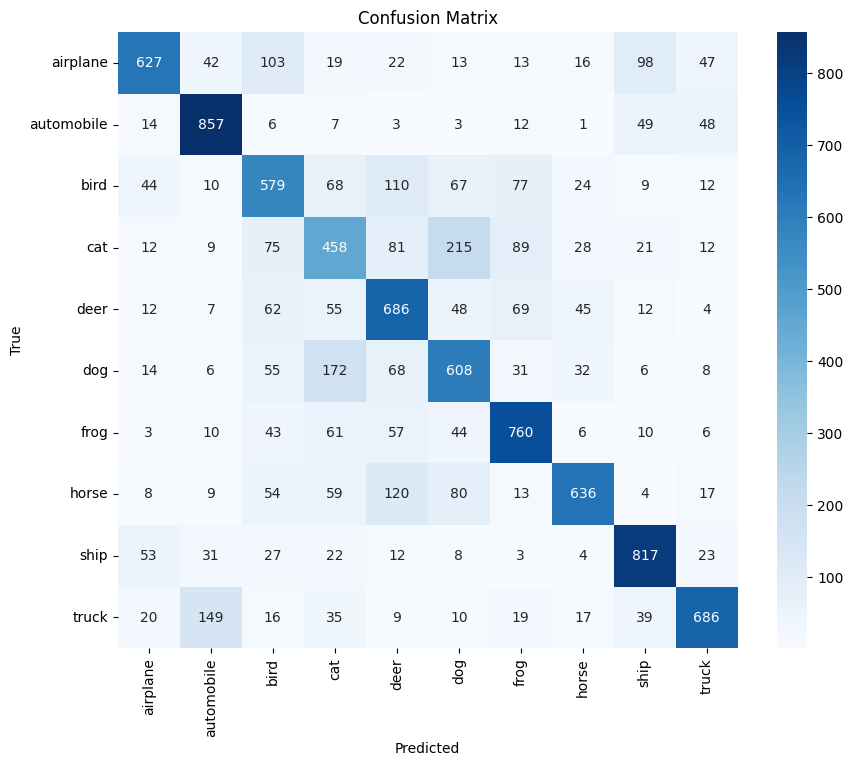

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#...... Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'



#....... Define CIFAR-10 mean and std for normalization
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.247, 0.243, 0.261)



# .......Define data augmentation and normalization transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])


#........tranfrom on test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])



# .....Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)



# .....Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)   # First convolution layer
        self.pool = nn.AvgPool2d(2, 2)               # Average pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # Second convolution layer
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5) # Third convolution layer
        self.fc1 = nn.Linear(120, 84)                # First fully connected layer
        self.fc2 = nn.Linear(84, 10)                 # Output layer



#......Forward pass
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 120)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    



# .....Instantiate the model, define the loss function and optimizer
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




# ....Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%')





# .....Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    


    # .....Calculate accuracy
    accuracy = 100 * np.mean(np.array(all_predictions) == np.array(all_labels))
    print(f'Validation Accuracy: {accuracy:.2f}%')
    


    #.... Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()



# ....Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, num_epochs=50)
evaluate_model(model, test_loader)
